In [ ]:
import tensorflow as tf

# Check GPU availability
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

GPU is available
TensorFlow version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/New_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import glob
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow import keras
from keras.models import Model
from keras.utils import plot_model
from keras.applications import vgg16
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
def Split_Folders(path):
    train_data_path = path

    filepaths =[]
    labels = []

    folds = os.listdir(train_data_path)

    for fold in folds:
        f_path = os.path.join(train_data_path , fold)
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path , file))
            labels.append(fold)

    #Concat data paths with labels
    labels = [path.replace('_tumor', '').title() for path in labels]
    Fseries = pd.Series(filepaths , name = 'Path')
    Lseries = pd.Series(labels , name = 'Label')
    New_df = pd.concat([Fseries , Lseries] , axis = 1)
    return New_df , filepaths , labels


In [ ]:
Train_path ='/content/New_Dataset/Training'
Test_path = '/content/New_Dataset/Testing'

train_df , train_paths,train_labels = Split_Folders(Train_path)
test_df , test_paths,test_labels = Split_Folders(Test_path)

In [ ]:
# 2 values in train_df and 1 in test_df have a un-defined tumor Class
train_df = train_df[train_df['Label'] != 'Tumor']
test_df = test_df[test_df['Label'] != 'Tumor']
#Getting class types
CLASS_TYPES = pd.unique(train_df['Label'])
N_TYPES = len(CLASS_TYPES)
print("Classes =",CLASS_TYPES)

Classes = ['Normal' 'Pituitary' 'Glioma' 'Meningioma']


In [ ]:
# Mapping dictionary
Dataset_classes = {'Normal': 0,
                 'Glioma': 1,
                 'Meningioma': 2,
                 'Pituitary': 3
}
# Apply mapping to both DataFrames
train_df['label_encoded'] = train_df['Label'].map(Dataset_classes)
test_df['label_encoded'] = test_df['Label'].map(Dataset_classes)

In [ ]:
train_df

,Path,Label,label_encoded
0,New_Dataset/Training/Normal/N_250_RO_.jpg,Normal,0
1,New_Dataset/Training/Normal/N_258_SP_.jpg,Normal,0
2,New_Dataset/Training/Normal/N_22_DA_.jpg,Normal,0
3,New_Dataset/Training/Normal/N_28_VF_.jpg_0_564...,Normal,0
4,New_Dataset/Training/Normal/N_110_RO_.jpg,Normal,0
...,...,...,...
19783,New_Dataset/Training/meningioma_tumor/M_224_SP...,Meningioma,2
19784,New_Dataset/Training/meningioma_tumor/M_56_SP_...,Meningioma,2
19785,New_Dataset/Training/meningioma_tumor/M_315_BR...,Meningioma,2
19786,New_Dataset/Training/meningioma_tumor/M_241_RO...,Meningioma,2


In [ ]:
# Reduced target size and batch size
target_size = (224, 224)
batch_size = 64

# Data Generators for VGG16
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Creating generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=Train_path,
    x_col='Path',
    y_col='Label',
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=Test_path,
    x_col='Path',
    y_col='Label',
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19788 validated image filenames belonging to 4 classes.
Found 4950 validated image filenames belonging to 4 classes.


In [ ]:
# Intialiase CNN
model = models.Sequential()


model.add(Conv2D(32, (4, 4), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=111))
model.add(Dense(N_TYPES, activation="softmax"))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 128)         0

In [ ]:
# addition of callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=6, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy')

# Training the model
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    validation_data=test_generator,
                    callbacks=[model_es, model_rlr, model_cp])

Epoch 1/50
310/310 [==============================] - 86s 253ms/step - loss: 1.8215 - accuracy: 0.6224 - val_loss: 0.6463 - val_accuracy: 0.7495 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 79s 255ms/step - loss: 0.5441 - accuracy: 0.7882 - val_loss: 0.4160 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 3/50
310/310 [==============================] - 75s 240ms/step - loss: 0.4043 - accuracy: 0.8488 - val_loss: 0.3280 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 4/50
310/310 [==============================] - 81s 262ms/step - loss: 0.3118 - accuracy: 0.8855 - val_loss: 0.2437 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 5/50
310/310 [==============================] - 83s 268ms/step - loss: 0.2396 - accuracy: 0.9106 - val_loss: 0.2221 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 6/50
310/310 [==============================] - 74s 239ms/step - loss: 0.2120 - accuracy: 0.9232 - val_loss: 0.2348 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 7/50
310/310 [==============================] - 85s 274ms/step - loss: 0.1946 - accuracy: 0.9319 - val_loss: 0.2129 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 8/50
310/310 [==============================] - 74s 239ms

In [ ]:
model.save("Best_CNN.h5")

In [ ]:
def generate_confusion_matrix(model, test_dataset, class_names):

    # Assuming test_dataset is a TensorFlow dataset
    true_labels = []
    predicted_labels = []

    for batch in test_dataset:
        images, labels = batch

        # Predict classes for the batch
        predictions = model.predict(images, verbose=False)
        predicted_classes = np.argmax(predictions, axis=1)

        # Convert one-hot encoded labels to class indices
        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print accuracy metrics using classification_report
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:\n", class_report)
    return cm

In [ ]:
cm = generate_confusion_matrix(model, test_dataset, list(Dataset_classes.keys()))

Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      1227
      Glioma       0.97      0.94      0.96      1262
  Meningioma       0.96      0.98      0.97      1279
   Pituitary       0.99      0.99      0.99      1182

    accuracy                           0.97      4950
   macro avg       0.98      0.98      0.97      4950
weighted avg       0.97      0.97      0.97      4950



In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

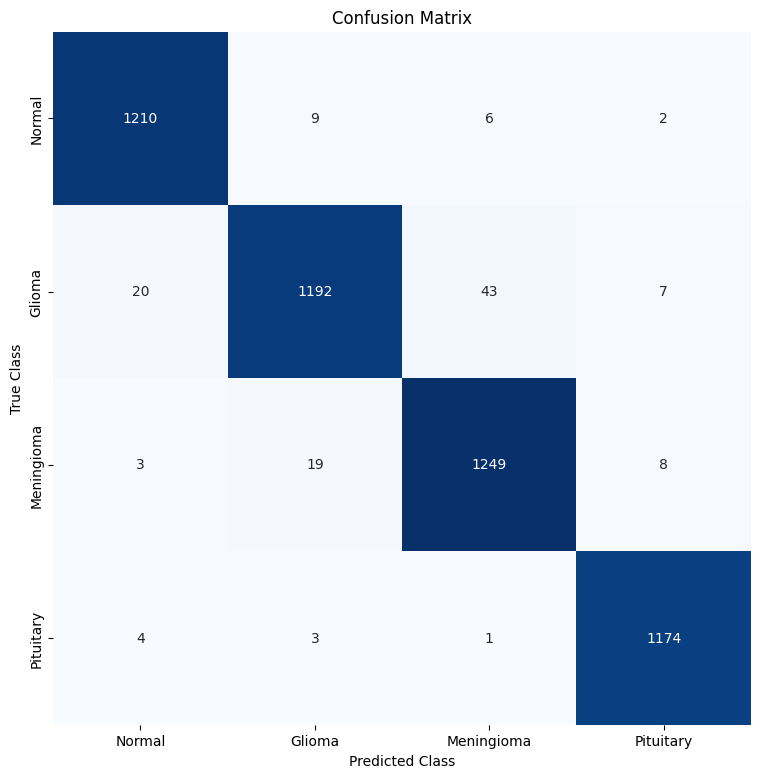

In [ ]:
plot_confusion_matrix(cm, list(Dataset_classes.keys()))

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()